# Introduction

Here we describe our analysis of the wikipedia traffic data.

# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor

In [2]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# Getting and Cleaning Data

We clean the data of NaN values by simply replacing each NaN value with the mean value of number of visits for each sample.

In [3]:
# Get the time series data.
data_df = pd.read_csv('train_2.csv')

print('data_df.shape = ', data_df.shape)
data_df.head()

data_df.shape =  (145063, 794)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [4]:
# Now fix NaN values in data_df.

means = data_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in data_df.columns:
    
    data_df[column].fillna(means, inplace = True)

data_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


# Page Features

## Breaking Up Page Data

Now we break up the Page data into the name of the page, the wikipedia project, the access, and the agent. We store these features in a separate dataframe, page_df.

In [5]:
# Let's get information from Page data.

urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in data_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

page_df = pd.DataFrame(data = pageInfo[0], columns = ['name'])

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    page_df[name] = infoCol

page_df.head()

,name,project,access,agent
0,2NE1,9,0,3
1,2PM,9,0,3
2,3C,9,0,3
3,4minute,9,0,3
4,52_Hz_I_Love_You,9,0,3


To get a rough idea of how features extracted from the name affect our predictions, for each sample we will make use of ratios of the mean target value of visits over the mean value of visits in the domain. Now, we will need to make predictions for 62 days worth of data, so we treat the last 62 days in our time series of visits as target data.

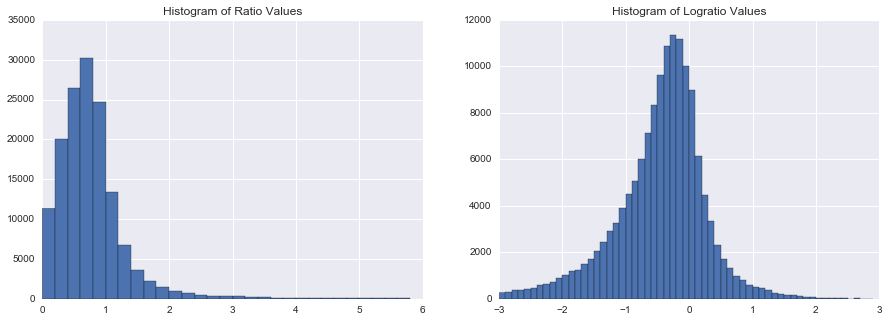

In [6]:
# Get the ratios of the means.

futureT = 62
epsilon = 1e-6

X_means = data_df.drop(['Page'], axis = 1).values[:, :-futureT].mean(axis = 1)
Y_means = data_df.drop(['Page'], axis = 1).values[:, -futureT:].mean(axis = 1)
ratios = Y_means / (epsilon + X_means)
page_df['ratios'] = ratios
page_df['logratios'] = np.log(epsilon + ratios)

doublefigsize = (15, 5)
plt.figure(figsize = doublefigsize)
plt.subplot('121')
page_df.ratios.hist(bins = np.arange(0, 6, 0.2))
plt.title('Histogram of Ratio Values')
plt.subplot('122')
page_df.logratios.hist(bins = np.arange(-3, 3, 0.1))
plt.title('Histogram of Logratio Values')
plt.show()

The histogram of ratio values is lop sided. We tried to fix it above by using the logarithm of the ratios. However, we see that the simple logarithm now has a tail on the left hand side. However, when we transform our ratios, it isn't necessarily best to transform the distribution into one resembling a Gaussian. Consider picking a value x to use as a prediction for a Gaussian distribution. For L2 regression, the optimal x to choose is the mean. However, for SMAPE, the optimal prediction should be below the median (which is the mean) since smape prefers over predictions to under predictions.

Let's us try to find a shift parameter such that the inverse transform of the mean value of the transformed distribution of Y_means is optimal for SMAPE score. This value should be related to optimizing smape score for L2 regression.

First let's see how the mean does as a predictor for the Y vals.

In [7]:
Y_vals = data_df.drop('Page', axis = 1).values[:, -futureT:]
Y_means = Y_vals.mean()
Y_means = np.full(Y_vals.shape, Y_means)
newsmape = smape(Y_vals, epsilon + Y_means)
print('Smape of just mean = ', newsmape)

Smape of just mean =  139.15566178


Now do a search over the optimal parameter param for a transformation z = np.log(param + y).

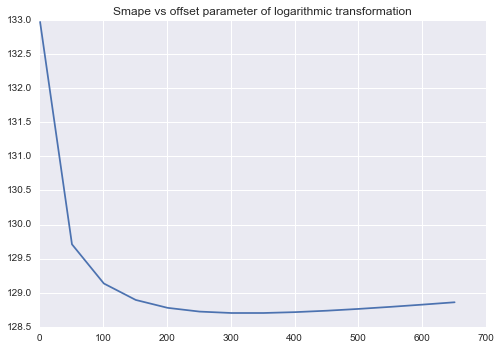

In [8]:
search = np.arange(1, 700, 50)

smapes = []
for param in search:
    Z_vals = np.log(param + Y_vals)
    Z_means = Z_vals.mean()
    Y_means = np.full(Y_vals.shape, -param + np.exp(Z_means))
    newsmape = smape(epsilon + Y_means, Y_vals)
    smapes.append(newsmape)
    
plt.plot(search, smapes)
plt.title('Smape vs offset parameter of logarithmic transformation')
plt.show()

So let's use the transform z = np.log(300 + y).

However, if we try training on the ratios of the Y vals to the mean of the X values, then we will need to use a different offset on the logarithm transformation.

Let's do a quick test of the smape for the Y_vals when predicting the ratio.

In [9]:
ratio_mean = page_df.ratios.mean()
Y_predict = (ratio_mean * X_means).reshape(-1, 1)
Y_predict = np.full(Y_vals.shape, Y_predict)
newsmape = smape(epsilon + Y_predict, Y_vals)
print('For simple ratio mean prediction, smape = ', newsmape)

For simple ratio mean prediction, smape =  81.3577548033


Now let's look at an offset search on logarithmic transformation of ratios.

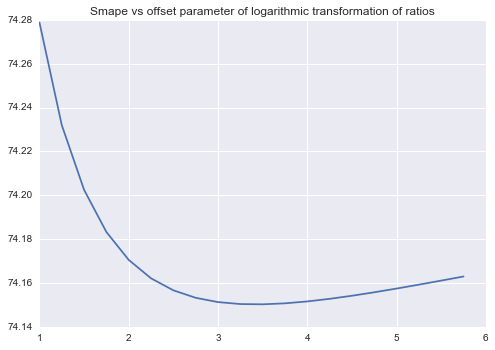

In [10]:
search = np.arange(1, 6, 0.25)

smapes = []
for param in search:
    Z_vals = np.log(param + page_df.ratios.values)
    Z_means = Z_vals.mean()
    ratio_predict = -param + np.exp(Z_means)
    Y_predict = (X_means * ratio_predict).reshape(-1,1)
    Y_predict = np.full(Y_vals.shape, Y_predict)
    newsmape = smape(epsilon + Y_predict, Y_vals)
    smapes.append(newsmape)
    
plt.plot(search, smapes)
plt.title('Smape vs offset parameter of logarithmic transformation of ratios')
plt.show()

So we see that the optimal constant to choose is about 3.5. So we go with z = np.log( 3.5 + Ratio ).

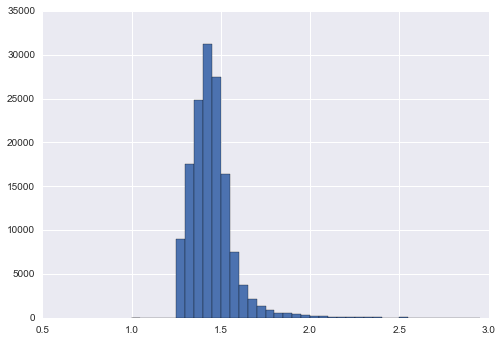

In [11]:
page_df.logratios = np.log(3.5 + page_df.ratios)

page_df.logratios.hist(bins = np.arange(1.0, 3, 0.05))
plt.show()

## Name Features

Now we look at creating features from the names.

### Number of Words in Name

Let's count the number of words in each name by counting the number of appearances of the character '_'.

In [12]:
# Let's count number of words in name.

numWords = []

for name in page_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)

page_df['numWords'] = numWords

Let's look at a histogram of word counts and how mean of log ratios depends on word counts.

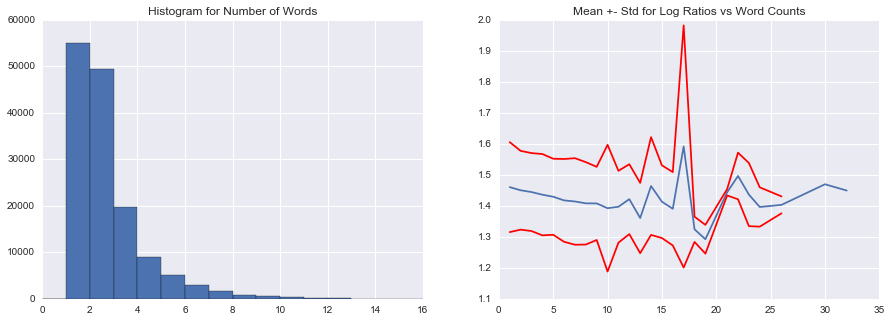

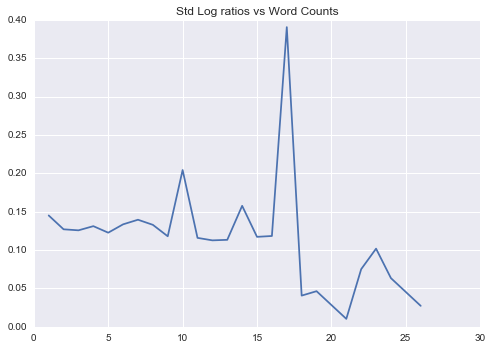

In [13]:
# Let's look at statistics for number of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df['numWords'].hist(bins = np.arange(17))
plt.title('Histogram for Number of Words')

grouped_mean = page_df.groupby('numWords').mean()
grouped_std = page_df.groupby('numWords').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Word Counts')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Word Counts')
plt.show()

### Counts of Numbers in Name

Now let's look at counting the numbers that occur in each name.

In [14]:
# Let's look at number of Numbers.

numNums = []
for name in page_df['name']:
    num = len(re.split(r'\d+', name))
    numNums.append(num)
        
numNums = np.array(numNums)

page_df['numNums'] = numNums

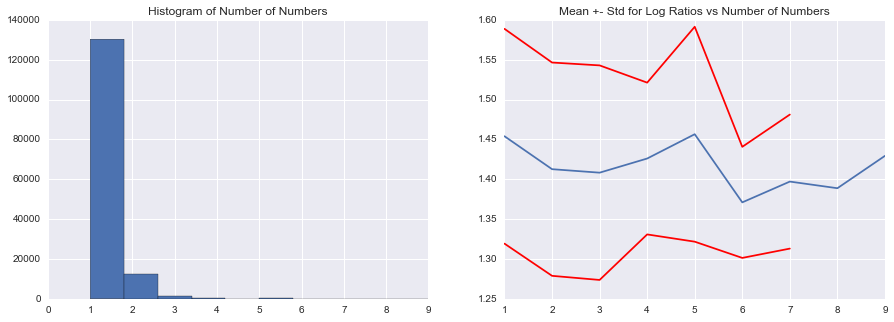

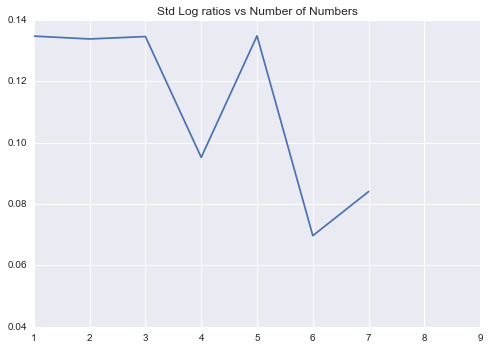

In [15]:
plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numNums.hist()
plt.title('Histogram of Number of Numbers')

grouped_mean = page_df.groupby('numNums').mean()
grouped_std = page_df.groupby('numNums').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Number of Numbers')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Number of Numbers')
plt.show()

### Size of First Number in Name

Now we extract the first number that appears in the name. We keep track of its size (i.e. itself).

In [16]:
# Let's get size of numbers inside names.

numSize = []
matches = []
for name in page_df['name']:
    match = re.search(r'\d+', name)
    matches.append(match)
    if match != None:
        num = float(match.group())
    else:
        num = 0
    numSize.append(num)

page_df['numSize'] = numSize

We look at a histogram of the positive numbers. We then adjust these values into two categories.

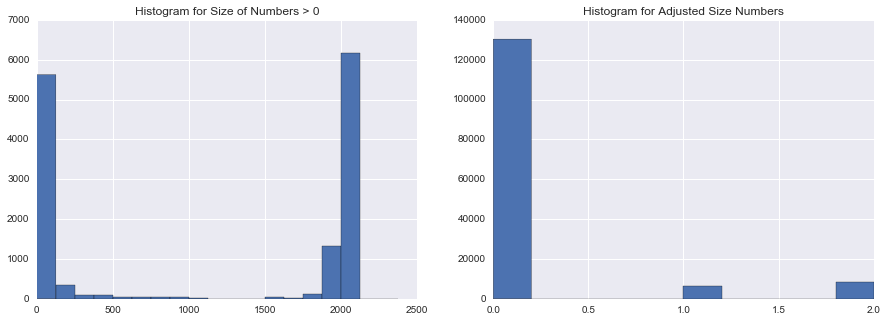

Proportion of Ajusted Number Size == 1 is  0.0437809779199
Proportion of Ajusted Number Size == 2 is  0.0579058753783
Mean Log Ratios by Adjusted Number Size
numSize2
0.0    1.453924
1.0    1.431765
2.0    1.398813
Name: logratios, dtype: float64


In [17]:
plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numSize.hist(bins = np.arange(1, 2.5e3, 2.5e3 / 20))
plt.title('Histogram for Size of Numbers > 0')


page_df['numSize2'] = page_df.numSize
mask = page_df.numSize2 > 0
page_df.loc[mask & (page_df.numSize2 < 1250), 'numSize2'] = 1
page_df.loc[mask & (page_df.numSize2 > 1), 'numSize2'] = 2

plt.subplot(122)
page_df.numSize2.hist()
plt.title('Histogram for Adjusted Size Numbers')
plt.show()

print('Proportion of Ajusted Number Size == 1 is ', np.sum(page_df.numSize2 == 1) / len(page_df.numSize2))
print('Proportion of Ajusted Number Size == 2 is ', np.sum(page_df.numSize2 == 2) / len(page_df.numSize2))

print('Mean Log Ratios by Adjusted Number Size')
print(page_df.groupby('numSize2').mean().logratios)